In [188]:
from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from datetime import datetime, time
import random 
import torch

from scipy.interpolate import BSpline, splrep, splev, splprep

import pandas
import seaborn as sns

from oceancolor.utils import plotting 
from oceancolor.iop import cross
from oceancolor.hydrolight import loisel23

from ihop import io as ihop_io
from ihop.iops import decompose 
from ihop.emulators import io as emu_io
from ihop.iops import io as iops_io
from ihop.inference import io as inf_io
from ihop.training_sets import load_rs

from pypeit.core import fitting
from pypeit.bspline import bspline

In [8]:
%matplotlib ipympl

# Load

In [4]:
ds = loisel23.load_ds(4,0)

In [6]:
idx = 170
wave = ds.Lambda.data
a_nw = ds.anw.data[idx]

## Plot

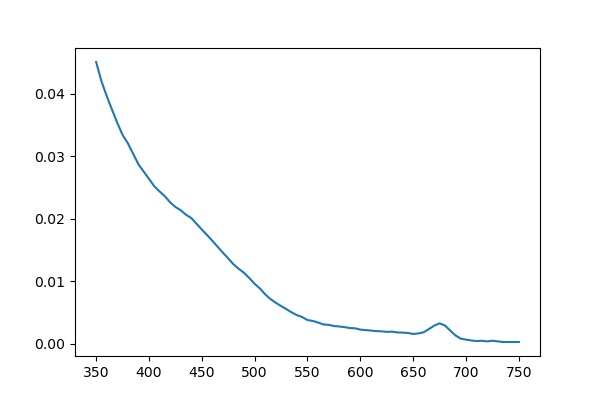

In [10]:
fig = plt.figure(figsize=(6,4))
ax = plt.gca()
#
ax.plot(wave, a_nw)
#
plt.show()

# Fit

## Prep

In [38]:
bkpts3 = [350. , 352.5, 367.5, 382.5, 397.5, 412.5, 427.5, 442.5, 457.5,
       472.5, 487.5, 502.5, 517.5, 532.5, 547.5, 562.5, 577.5, 592.5] + [
           625., 640., 660., 670., 680., 690, 705, 725., 755]
bkpts3 = np.array(bkpts3)

In [157]:
bkpts3 = [350.] + np.linspace(352., 660., 10).tolist() + [660., 670., 680., 690, 705, 725., 740., 755]
bkpts3 = np.array(bkpts3)

In [158]:
my_bspline = bspline(wave, nord=3, fullbkpt=bkpts3)

## Try one

In [159]:
code, yfit = my_bspline.fit(wave.astype(np.float64), a_nw.astype(np.float64),
                        np.ones_like(wave))

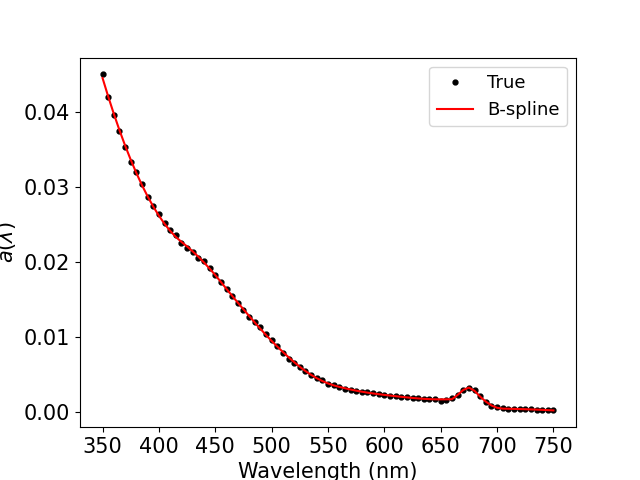

In [187]:
fig = plt.figure()
plt.clf()
ax = plt.gca()
#
# Data
ax.plot(wave, a_nw, 'ko', ms=3.5, label='True')
# Breakpoints
#ax.plot(my_bspline.breakpoints, 
#        0.002*np.ones(len(my_bspline.breakpoints)), '*', color='gray')

# Fit
ax.plot(wave, yfit, 'r-', label='B-spline')

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel(r'$a(\lambda)$')
plotting.set_fontsize(ax, 15)
ax.legend(fontsize=13.)

plt.show()

In [161]:
my_bspline.coeff.size

16

In [162]:
my_bspline.breakpoints.size

19

In [169]:
icoeff = my_bspline.icoeff.copy()
my_bspline.icoeff[:] = 0.

In [170]:
wv64 = wave.astype(np.float64)
a1, lower, upper = my_bspline.action(wv64)
yfit2, foo = my_bspline.value(wv64, action=a1, upper=upper, lower=lower)

In [172]:
my_bspline.icoeff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

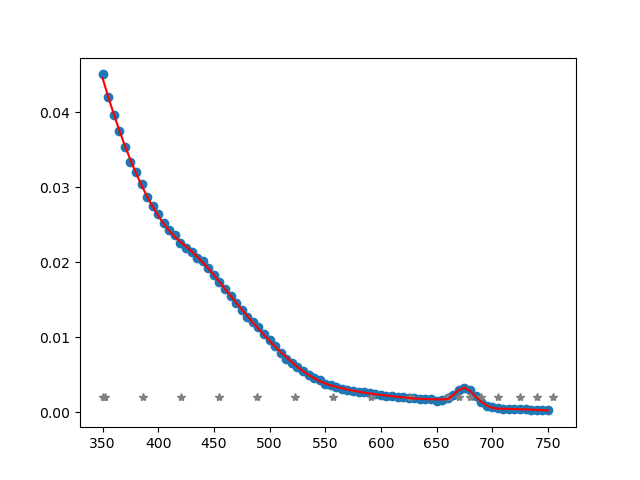

In [171]:
fig = plt.figure()
plt.clf()
ax = plt.gca()
#
# Data
ax.plot(wave, a_nw, 'o')
# Breakpoints
ax.plot(my_bspline.breakpoints, 
        0.002*np.ones(len(my_bspline.breakpoints)), '*', color='gray')

# Fit
ax.plot(wave, yfit2, 'r-')

plt.show()

In [180]:
bdict = my_bspline.to_dict()
#bdict

In [178]:
my_bsp2 = bspline.from_dict(bdict)

TypeError: Cannot assign object of type <class 'list'> to breakpoints.
Allowed type(s) are: <class 'numpy.ndarray'>

----

# Scipy

In [154]:
bkpts4 = np.linspace(352., 660., 10).tolist() + [670., 680., 690, 705, 725., 745] 
bkpts5 = [350.]+bkpts4+[750.]
bkpts4 = np.array(bkpts4)
bkpts5 = np.array(bkpts5)

In [84]:
bkpts4

array([352.        , 386.22222222, 420.44444444, 454.66666667,
       488.88888889, 523.11111111, 557.33333333, 591.55555556,
       625.77777778, 660.        , 670.        , 680.        ,
       690.        , 705.        , 725.        , 745.        ])

In [85]:
n_interior_knots = 5
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(wave, qs)

In [189]:
#tck, u = splprep([wave, a_nw], t=bkpts5, k=3, task=-1, s=0)
#tck, u = splprep([wave, a_nw], s=0)
#tck = splrep(wave, a_nw, t=knots, k=3)
tck = splrep(wave, a_nw, t=bkpts4, k=3)

In [152]:
tck

[array([0., 0., 0., 0., 1., 1., 1., 1.]),
 [array([349.99999875, 483.33332719, 616.66666617, 749.99999973]),
  array([ 0.04274886, -0.00405616,  0.00277766,  0.0004766 ])],
 3]

In [145]:
ys_smooth = splev(wave, tck)

In [146]:
tck

(array([350.        , 350.        , 350.        , 350.        ,
        352.        , 386.22222222, 420.44444444, 454.66666667,
        488.88888889, 523.11111111, 557.33333333, 591.55555556,
        625.77777778, 660.        , 670.        , 680.        ,
        690.        , 705.        , 725.        , 745.        ,
        750.        , 750.        , 750.        , 750.        ]),
 array([0.045041  , 0.04399167, 0.0381386 , 0.02847058, 0.02251615,
        0.01779518, 0.01107808, 0.00583958, 0.00320164, 0.00240534,
        0.00207527, 0.00120137, 0.00286958, 0.00351823, 0.0006083 ,
        0.00053825, 0.00044207, 0.00027137, 0.00030073, 0.0003    ,
        0.        , 0.        , 0.        , 0.        ]),
 3)

In [147]:
#tck2 = (tck[0].copy(), tck[1].copy(), tck[2])
tck2 = (tck[0][3:-3], tck[1][3:-3], tck[2])

In [148]:
tck2

(array([350.        , 352.        , 386.22222222, 420.44444444,
        454.66666667, 488.88888889, 523.11111111, 557.33333333,
        591.55555556, 625.77777778, 660.        , 670.        ,
        680.        , 690.        , 705.        , 725.        ,
        745.        , 750.        ]),
 array([0.02847058, 0.02251615, 0.01779518, 0.01107808, 0.00583958,
        0.00320164, 0.00240534, 0.00207527, 0.00120137, 0.00286958,
        0.00351823, 0.0006083 , 0.00053825, 0.00044207, 0.00027137,
        0.00030073, 0.0003    , 0.        ]),
 3)

In [149]:
ys_smooth2 = splev(wave, tck2)

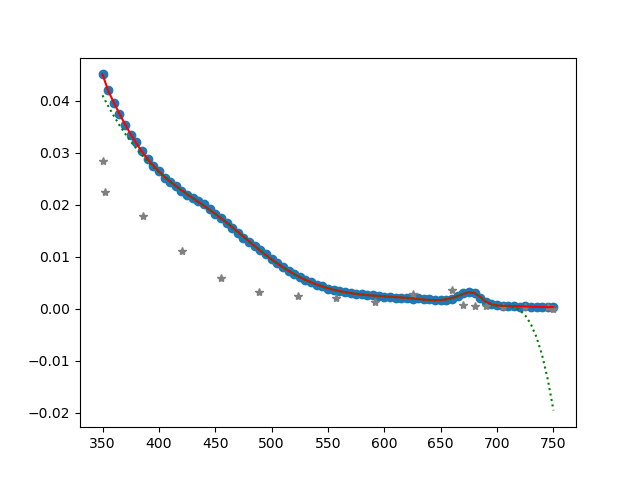

In [150]:
fig = plt.figure()
plt.clf()
ax = plt.gca()
#
# Data
ax.plot(wave, a_nw, 'o')
# Breakpoints
ax.plot(tck2[0], tck2[1], '*', color='gray')

# Fit
ax.plot(wave, ys_smooth, 'r-')
ax.plot(wave, ys_smooth2, 'g:')

plt.show()

----

# Test Re-construct

In [222]:
dfile = iops_io.loisel23_filename('bsp', 'a', 10, 4, 0)
d = np.load(dfile)

In [223]:
#my_bspline.to_dict()

In [224]:
d['coeffs'].shape

(3320, 15)

In [225]:
d['coeffs'][0]

array([0.01904186, 0.0134786 , 0.0105846 , 0.00735047, 0.00453577,
       0.00249643, 0.00174612, 0.00127096, 0.00095089, 0.00110593,
       0.00156727, 0.00086327, 0.00033129, 0.00028415, 0.0002071 ])

In [232]:
idx = 500
new_dict = my_bspline.to_dict().copy()
# Fill in
new_dict['breakpoints'] = d['breakpoints']
new_dict['coeff'] = d['coeffs'][idx]
new_dict['mask'] = np.ones_like(d['breakpoints'], dtype=bool)
new_dict['icoeff'] = np.zeros_like(d['breakpoints'])
#
new_dict

{'breakpoints': array([350.        , 352.        , 386.22222222, 420.44444444,
        454.66666667, 488.88888889, 523.11111111, 557.33333333,
        591.55555556, 625.77777778, 660.        , 670.        ,
        680.        , 690.        , 705.        , 725.        ,
        745.        , 755.        ]),
 'nord': 3,
 'npoly': 1,
 'mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True]),
 'coeff': array([0.03763177, 0.02402083, 0.01936854, 0.01237764, 0.00713503,
        0.00354802, 0.00252569, 0.00191204, 0.00141264, 0.00188563,
        0.00280338, 0.00153423, 0.00063653, 0.00050312, 0.0003778 ]),
 'icoeff': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 'xmin': 0.0,
 'xmax': 1.0,
 'funcname': 'legendre'}

## Init

In [233]:
#new_dict['coeff'] = np.array([0.01904186, 0.0134786 , 0.0105846 , 0.00735047, 0.00453577,
#       0.00249643, 0.00174612, 0.00127096, 0.00095089, 0.00110593,
#       0.00156727, 0.00086327, 0.00033129, 0.00028415, 0.0002071 ])

In [234]:
new_bspline = bspline(wave, from_dict=new_dict)

In [235]:
new_y, _ = new_bspline.value(wave.astype(np.float64))

## Plot

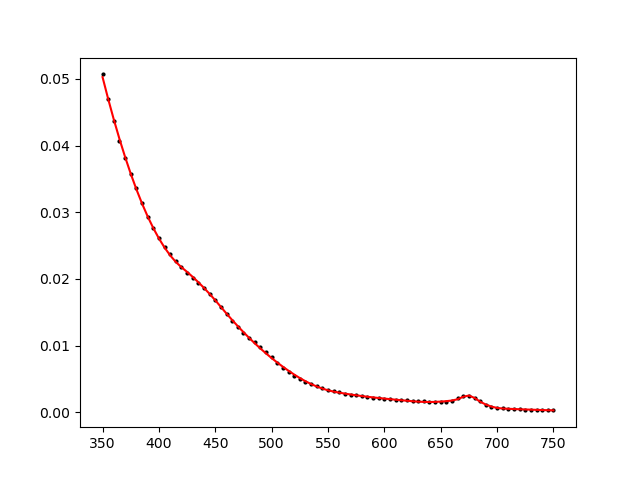

In [236]:
new_a_nw = ds.anw.data[idx]
fig = plt.figure()
plt.clf()
ax = plt.gca()
#
# Data
ax.plot(wave, new_a_nw, 'ko', ms=2)
# Breakpoints
#ax.plot(tck2[0], tck2[1], '*', color='gray')

# Fit
ax.plot(wave, new_y, 'r-')
#ax.plot(wave, ys_smooth2, 'g:')

plt.show()